In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)

In [2]:
set.seed(1)

In [3]:
# valid columns when high speed
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150')

In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
CV <- function(dfx, expr, verbose=FALSE) {        
    folds <- createFolds(dfx$flag)
    
    count <- 1
    errs <- c()
    reds <- c()
    blues <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        # fit <- rpart(expr, data=train, method="class")
        fit <- rpart(expr, data=train, method="class", cp=0.024)
        p <- predict(fit, newdata=test)
        predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]
        
        if (verbose) {            
            printf("Fold%d\n", count)
            result <- correctVsPredict(test, predictedFlags)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
            count <- count + 1
            printf("\n")
        }
        
        nerr <- sum((predictedFlags == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(c(mean(errs), mean(reds), mean(blues)))
}

In [6]:
correctVsPredict <- function(test, predictedFlags) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
    printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [7]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [8]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Red

In [9]:
df3 <- read.csv("../data/middle/sp2.csv", stringsAsFactors=FALSE)

In [10]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [11]:
allFeatures <- c(colnames(df3))
expr <- createFormula(invalids, allFeatures)

In [12]:
result <- CV(df3, expr, verbose=TRUE)
printRedRatios(df3)
printf("Red: Mean correct/predict = %f\n", result[2])
printf("Blue: Mean correct/predict = %f\n", result[3])
printf("CV value: %f", result[1])

Fold1
As for Red: correct/predict = 44/69 = 0.637681
As for Blue: correct/predict = 19/35 = 0.542857

Fold2
As for Red: correct/predict = 42/67 = 0.626866
As for Blue: correct/predict = 20/38 = 0.526316

Fold3
As for Red: correct/predict = 46/74 = 0.621622
As for Blue: correct/predict = 17/30 = 0.566667

Fold4
As for Red: correct/predict = 45/66 = 0.681818
As for Blue: correct/predict = 24/38 = 0.631579

Fold5
As for Red: correct/predict = 40/60 = 0.666667
As for Blue: correct/predict = 25/44 = 0.568182

Fold6
As for Red: correct/predict = 43/71 = 0.605634
As for Blue: correct/predict = 17/33 = 0.515152

Fold7
As for Red: correct/predict = 45/67 = 0.671642
As for Blue: correct/predict = 23/38 = 0.605263

Fold8
As for Red: correct/predict = 46/64 = 0.718750
As for Blue: correct/predict = 27/40 = 0.675000

Fold9
As for Red: correct/predict = 47/75 = 0.626667
As for Blue: correct/predict = 17/29 = 0.586207

Fold10
As for Red: correct/predict = 43/74 = 0.581081
As for Blue: correct/predict

In [13]:
fit3 <- rpart(expr, data=df3, method="class")

In [14]:
fit3$cptable[which.min(fit3$cptable[,"xerror"]),"CP"]

[1] 0.02449889

In [15]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

           CP nsplit rel error    xerror       xstd
1  0.03786192      0 1.0000000 1.0000000 0.03560167
2  0.02672606      3 0.8864143 0.9376392 0.03527822
3  0.02449889      5 0.8329621 0.8997773 0.03502844
4  0.02227171      6 0.8084633 0.8997773 0.03502844
5  0.01893096      7 0.7861915 0.9109131 0.03510616
6  0.01559020      9 0.7483296 0.9465479 0.03533107
7  0.01336303     10 0.7327394 0.9398664 0.03529164
8  0.01224944     13 0.6926503 0.9465479 0.03533107
9  0.01002227     16 0.6547884 0.9532294 0.03536925
10 0.01000000     18 0.6347439 0.9532294 0.03536925

Variable importance
            Speed     AheadDistance   AverageVelocity       TimeHeadway 
               15                 9                 9                 9 
         RoadType   TimeToCollision        RiskFactor      CurveAverage 
                8                 8                 8                 7 
            Curve            Engine          

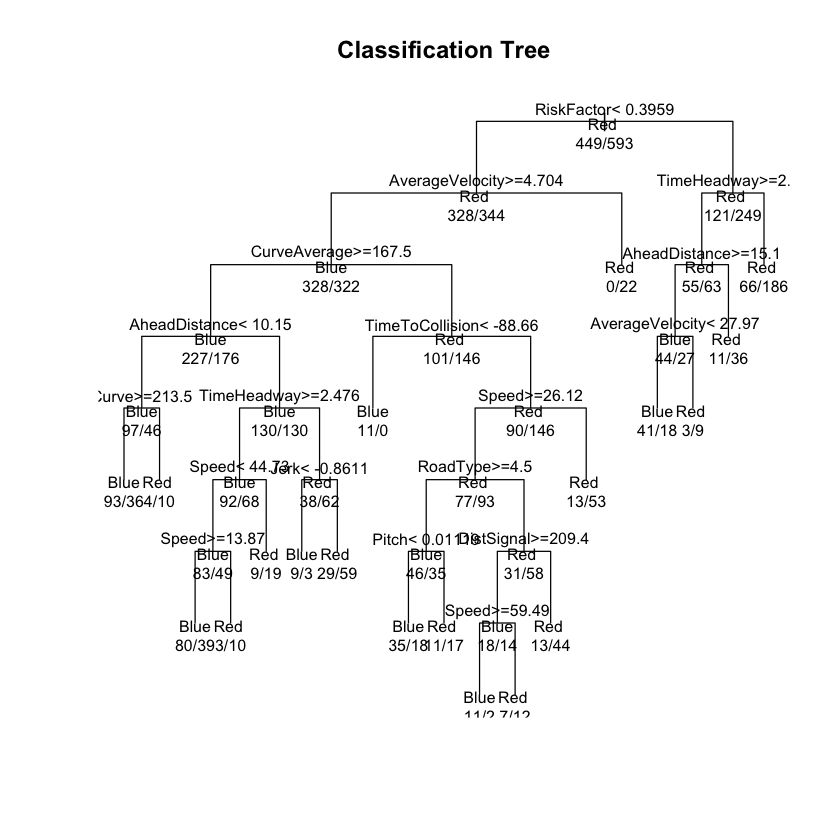

In [18]:
plot(fit3, uniform=TRUE, main="Classification Tree")
text(fit3, use.n=TRUE, all=TRUE, cex=.8)